In [ ]:
%load_ext autoreload
%autoreload 2

## Treg and Macrophage interactions through GITR/GITRL
<br>
<b>Description</b> : In this notebook we run Tangram2 and Intergram on human lymph node data.<br>
<b>Author</b> : Alma Andersson (andera29@gene.com)<br>
<b>Date</b> : 11/14/2024

Import necessary packages

In [2]:
import telegraph as tg
import pandas as pd
import anndata as ad
import os.path as osp
import seaborn as sns
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import gseapy as gp
import kneed
import pickle as pkl
import os

Define helper functions

In [ ]:
def read_h5ad_uniqify(path,tag = None):
    adata = ad.read_h5ad(path)
    adata.obs_names_make_unique()
    adata.var_names_make_unique()
    if tag is not None:
        adata.obs_names  = [f'{tag}_{x}' for x in adata.obs_names]
    return adata

def pp_adata(ad_sc,ad_sp = None, label_col = None):
    is_mt = ad_sc.var_names.str.startswith(("mt-","mt","mir",'ac0','linc','itgb'))
    is_rp = ad_sc.var_names.str.startswith(("rps", "rpl","rp-","rp"))
    is_iso = ad_sc.var_names.str.endswith(tuple(['.' + str(i) for i in range(50)]))
    is_orf = np.array(['orf' in x for x in ad_sc.var_names])
    is_as = np.array(['-as' in x for x in ad_sc.var_names])
    keep_genes = (~is_mt) & (~is_rp)  & (~is_orf) & (~is_iso) & (~is_as)
    ad_sc = ad_sc[:,keep_genes].copy()

    sc.pp.filter_cells(ad_sc,min_counts=300)
    
    sc.pp.filter_genes(ad_sc,min_counts=10)

    if ad_sp is not None:
        sc.pp.filter_cells(ad_sp,min_counts=100)
        sc.pp.filter_genes(ad_sp,min_counts=10)
  

    ad_sc.layers['raw'] = ad_sc.X.copy()
    sc.pp.normalize_total(ad_sc,1e4)
    sc.pp.log1p(ad_sc)

    if label_col is not None:
        sc.tl.rank_genes_groups(ad_sc, groupby=label_col)
    sc.pp.highly_variable_genes(ad_sc,n_top_genes=5000)
    ad_sc.layers['norm'] = ad_sc.X.copy()
    ad_sc.X = ad_sc.layers['raw'].copy()

    if ad_sp is not None:
        return ad_sc,ad_sp
    return ad_sc


Define directories for spatial and single cell data

In [3]:
SC_DIR = '../../data/imod/sc/'
SP_DIR = '../../data/imod/sp/'

Define output directory

In [ ]:
with open('OUTPUT_DIR.txt','r+') as f:
    OUTPUT_ROOT = f.readlines()[0]

OUTPUT_DIR = osp.join(OUTPUT_ROOT, 'mac_treg')
os.makedirs(OUTPUT_DIR, exist_ok = True)

get patient ids (used to load data)

In [4]:
patient_ids = list(set([ x.split('_')[0] for x in os.listdir(SP_DIR)]))

Set label column (used in both tangram and intergram)

In [7]:
label_col = 'level3_celltype'

Run analysis on a per-patient level

In [8]:
beta_res = dict()
for pat in patient_ids:

    print(pat)
    sp_files = [x for x in os.listdir(SP_DIR) if x.startswith(pat)]
    print(sp_files)
    ad_sp =  ad.concat([read_h5ad_uniqify(osp.join(SP_DIR,fn)) for fn in sp_files])
    sc_fn = [x for x in os.listdir(SC_DIR) if x.startswith(pat)][0]
    print(sc_fn)
    ad_sc = ad.read_h5ad(osp.join(SC_DIR,sc_fn))
    ad_sc.var_names = [x.lower() for x in ad_sc.var_names]
    ad_sp.var_names = [x.lower() for x in ad_sp.var_names]
    ad_sc,ad_sp = pp_adata(ad_sc,ad_sp)

    hvg_genes = ad_sc.var_names[ad_sc.var.highly_variable.values].tolist()
    
    input_dict_1 = tg.met.utils.adatas_to_input({'from':ad_sc, 'to':ad_sp}, # provide the data to be used
                                                        categorical_labels={'from':[label_col]}, # include cluster labels in the design matrix
                                                      )
    
    tg.met.pp.StandardTangramV2.run(input_dict_1)
    
    map_res_1 = tg.met.map_methods.TangramV2Map.run(input_dict_1,
                                                    num_epochs = 1000,
                                                    genes =hvg_genes,
                                                 )
    
    input_dict_1.update(map_res_1)

    tg.met.pp.StandardScanpy.run(input_dict_1,target_objs = ['X_from'])

    inter_res = tg.dev.imod.methods.InteractionModel.run(input_dict_1,
                                                         n_epochs = 1000,
                                                         learning_rate = 0.01)

    beta_vals = inter_res['beta'].to_dataframe().copy()
    beta_res[pat] = beta_vals

P5
['P5_rep2.h5ad', 'P5_rep1.h5ad', 'P5_rep3.h5ad']
P5_normal+tumor.h5ad


INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 4086 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Set Solid Seed
Set Solid Seed
Score: 0.544, KL reg: 3.840, Entropy reg: -10.457
Score: 0.688, KL reg: 3.555, Entropy reg: -8.510
Score: 0.689, KL reg: 3.555, Entropy reg: -8.456
Score: 0.689, KL reg: 3.555, Entropy reg: -8.411
Score: 0.689, KL reg: 3.555, Entropy reg: -8.392
Score: 0.690, KL reg: 3.555, Entropy reg: -8.383
Score: 0.690, KL reg: 3.555, Entropy reg: -8.378
Score: 0.690, KL reg: 3.555, Entropy reg: -8.376
Score: 0.690, KL reg: 3.555, Entropy reg: -8.374


INFO:root:Renormalizing Single cell data


Score: 0.690, KL reg: 3.555, Entropy reg: -8.373


INFO:root:Begin training with 4086 genes and rna_count_based density_prior in cells mode after renormalization


Set Solid Seed


INFO:root:Printing scores every 100 epochs.


Set Solid Seed
Score: 0.681, KL reg: 0.261, Entropy reg: -17201.100
Score: 0.712, KL reg: 0.000, Entropy reg: -15244.469
Score: 0.718, KL reg: 0.000, Entropy reg: -12012.729
Score: 0.720, KL reg: 0.000, Entropy reg: -9448.761
Score: 0.721, KL reg: 0.000, Entropy reg: -7597.306
Score: 0.722, KL reg: 0.000, Entropy reg: -5854.018
Score: 0.723, KL reg: 0.000, Entropy reg: -4617.027
Score: 0.723, KL reg: 0.000, Entropy reg: -3996.613
Score: 0.723, KL reg: 0.000, Entropy reg: -3705.643
Score: 0.723, KL reg: 0.000, Entropy reg: -3583.850


INFO:root:Saving results..
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 631 K  | n/a 
---------------------------------------------
631 K     Trainable params
0         Non-trainable params
631 K     Total params
2.524     Total estimated model params size (MB)


Training: |                                                                     | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


P4
['P4_rep1.h5ad', 'P4_rep2.h5ad']
P4_normal+tumor.h5ad


INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 4209 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Set Solid Seed
Set Solid Seed
Score: 0.527, KL reg: 3.645, Entropy reg: -9.973
Score: 0.781, KL reg: 3.219, Entropy reg: -7.422
Score: 0.782, KL reg: 3.219, Entropy reg: -7.390
Score: 0.782, KL reg: 3.219, Entropy reg: -7.381
Score: 0.783, KL reg: 3.219, Entropy reg: -7.376
Score: 0.783, KL reg: 3.219, Entropy reg: -7.374
Score: 0.783, KL reg: 3.219, Entropy reg: -7.373
Score: 0.783, KL reg: 3.219, Entropy reg: -7.373
Score: 0.783, KL reg: 3.219, Entropy reg: -7.372
Score: 0.783, KL reg: 3.219, Entropy reg: -7.372


INFO:root:Renormalizing Single cell data
INFO:root:Begin training with 4209 genes and rna_count_based density_prior in cells mode after renormalization


Set Solid Seed


INFO:root:Printing scores every 100 epochs.


Set Solid Seed
Score: 0.762, KL reg: 0.398, Entropy reg: -53757.414
Score: 0.845, KL reg: 0.001, Entropy reg: -36112.820
Score: 0.863, KL reg: 0.000, Entropy reg: -15108.834
Score: 0.867, KL reg: 0.000, Entropy reg: -7125.104
Score: 0.868, KL reg: 0.000, Entropy reg: -5059.123
Score: 0.868, KL reg: 0.000, Entropy reg: -4753.459
Score: 0.869, KL reg: 0.000, Entropy reg: -4720.686
Score: 0.869, KL reg: 0.000, Entropy reg: -4740.515
Score: 0.869, KL reg: 0.000, Entropy reg: -4756.144
Score: 0.869, KL reg: 0.000, Entropy reg: -4766.768


INFO:root:Saving results..
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 326 K  | n/a 
---------------------------------------------
326 K     Trainable params
0         Non-trainable params
326 K     Total params
1.304     Total estimated model params size (MB)


Training: |                                                                     | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


P6
['P6_rep1.h5ad', 'P6_rep2.h5ad']
P6_normal+tumor.h5ad


INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 4522 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Set Solid Seed
Set Solid Seed
Score: 0.553, KL reg: 4.638, Entropy reg: -11.977
Score: 0.714, KL reg: 3.555, Entropy reg: -8.855
Score: 0.717, KL reg: 3.555, Entropy reg: -8.654
Score: 0.718, KL reg: 3.555, Entropy reg: -8.601
Score: 0.719, KL reg: 3.555, Entropy reg: -8.580
Score: 0.719, KL reg: 3.555, Entropy reg: -8.571
Score: 0.719, KL reg: 3.555, Entropy reg: -8.566
Score: 0.720, KL reg: 3.555, Entropy reg: -8.564
Score: 0.720, KL reg: 3.555, Entropy reg: -8.563
Score: 0.720, KL reg: 3.555, Entropy reg: -8.561


INFO:root:Renormalizing Single cell data
INFO:root:Begin training with 4522 genes and rna_count_based density_prior in cells mode after renormalization


Set Solid Seed


INFO:root:Printing scores every 100 epochs.


Set Solid Seed
Score: 0.678, KL reg: 1.057, Entropy reg: -56059.805
Score: 0.757, KL reg: 0.000, Entropy reg: -44183.922
Score: 0.769, KL reg: 0.000, Entropy reg: -39704.059
Score: 0.772, KL reg: 0.000, Entropy reg: -37436.586
Score: 0.774, KL reg: 0.000, Entropy reg: -35842.453
Score: 0.775, KL reg: 0.000, Entropy reg: -34754.180
Score: 0.775, KL reg: 0.000, Entropy reg: -33734.883
Score: 0.776, KL reg: 0.000, Entropy reg: -32703.785
Score: 0.776, KL reg: 0.000, Entropy reg: -31657.230
Score: 0.776, KL reg: 0.000, Entropy reg: -30589.547


INFO:root:Saving results..
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 631 K  | n/a 
---------------------------------------------
631 K     Trainable params
0         Non-trainable params
631 K     Total params
2.524     Total estimated model params size (MB)


Training: |                                                                     | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


P2
['P2_rep1.h5ad', 'P2_rep2.h5ad', 'P2_rep3.h5ad']
P2_normal+tumor.h5ad


INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 4467 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Set Solid Seed
Set Solid Seed
Score: 0.635, KL reg: 4.030, Entropy reg: -10.637
Score: 0.783, KL reg: 3.555, Entropy reg: -8.463
Score: 0.785, KL reg: 3.555, Entropy reg: -8.330
Score: 0.785, KL reg: 3.555, Entropy reg: -8.288
Score: 0.785, KL reg: 3.555, Entropy reg: -8.272
Score: 0.785, KL reg: 3.555, Entropy reg: -8.267
Score: 0.786, KL reg: 3.555, Entropy reg: -8.260
Score: 0.786, KL reg: 3.555, Entropy reg: -8.257
Score: 0.786, KL reg: 3.555, Entropy reg: -8.256


INFO:root:Renormalizing Single cell data


Score: 0.786, KL reg: 3.555, Entropy reg: -8.255


INFO:root:Begin training with 4467 genes and rna_count_based density_prior in cells mode after renormalization


Set Solid Seed


INFO:root:Printing scores every 100 epochs.


Set Solid Seed
Score: 0.753, KL reg: 0.453, Entropy reg: -48286.203
Score: 0.807, KL reg: 0.000, Entropy reg: -40880.836
Score: 0.816, KL reg: 0.000, Entropy reg: -33301.242
Score: 0.821, KL reg: 0.000, Entropy reg: -25956.898
Score: 0.823, KL reg: 0.000, Entropy reg: -20596.043
Score: 0.824, KL reg: 0.000, Entropy reg: -16832.914
Score: 0.824, KL reg: 0.000, Entropy reg: -13729.883
Score: 0.825, KL reg: 0.000, Entropy reg: -11323.500
Score: 0.825, KL reg: 0.000, Entropy reg: -9210.843
Score: 0.825, KL reg: 0.000, Entropy reg: -7881.700


INFO:root:Saving results..
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 631 K  | n/a 
---------------------------------------------
631 K     Trainable params
0         Non-trainable params
631 K     Total params
2.524     Total estimated model params size (MB)


Training: |                                                                     | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


P10
['P10_rep1.h5ad', 'P10_rep3.h5ad', 'P10_rep2.h5ad']
P10_normal+tumor.h5ad


INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 3614 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Set Solid Seed
Set Solid Seed
Score: 0.545, KL reg: 4.223, Entropy reg: -10.433
Score: 0.737, KL reg: 3.497, Entropy reg: -7.571
Score: 0.739, KL reg: 3.497, Entropy reg: -7.454
Score: 0.739, KL reg: 3.497, Entropy reg: -7.440
Score: 0.739, KL reg: 3.497, Entropy reg: -7.442
Score: 0.740, KL reg: 3.497, Entropy reg: -7.438
Score: 0.740, KL reg: 3.497, Entropy reg: -7.436
Score: 0.740, KL reg: 3.497, Entropy reg: -7.436
Score: 0.740, KL reg: 3.497, Entropy reg: -7.437
Score: 0.740, KL reg: 3.497, Entropy reg: -7.438


INFO:root:Renormalizing Single cell data
INFO:root:Begin training with 3614 genes and rna_count_based density_prior in cells mode after renormalization


Set Solid Seed


INFO:root:Printing scores every 100 epochs.


Set Solid Seed
Score: 0.728, KL reg: 0.694, Entropy reg: -31671.365
Score: 0.769, KL reg: 0.000, Entropy reg: -24512.906
Score: 0.780, KL reg: 0.000, Entropy reg: -18945.451
Score: 0.783, KL reg: 0.000, Entropy reg: -15635.052
Score: 0.785, KL reg: 0.000, Entropy reg: -12858.324
Score: 0.786, KL reg: 0.000, Entropy reg: -10362.582
Score: 0.786, KL reg: 0.000, Entropy reg: -8018.361
Score: 0.787, KL reg: 0.000, Entropy reg: -6380.296
Score: 0.787, KL reg: 0.000, Entropy reg: -5432.754
Score: 0.787, KL reg: 0.000, Entropy reg: -5006.127


INFO:root:Saving results..
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 562 K  | n/a 
---------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.248     Total estimated model params size (MB)


Training: |                                                                     | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


P9
['P9_rep1.h5ad', 'P9_rep3.h5ad', 'P9_rep2.h5ad']
P9_normal+tumor.h5ad


INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 3904 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Set Solid Seed
Set Solid Seed
Score: 0.544, KL reg: 4.311, Entropy reg: -11.140
Score: 0.672, KL reg: 3.526, Entropy reg: -8.554
Score: 0.674, KL reg: 3.526, Entropy reg: -8.401
Score: 0.674, KL reg: 3.526, Entropy reg: -8.355
Score: 0.674, KL reg: 3.526, Entropy reg: -8.333
Score: 0.674, KL reg: 3.526, Entropy reg: -8.319
Score: 0.674, KL reg: 3.526, Entropy reg: -8.310
Score: 0.674, KL reg: 3.526, Entropy reg: -8.305
Score: 0.674, KL reg: 3.526, Entropy reg: -8.301
Score: 0.674, KL reg: 3.526, Entropy reg: -8.298


INFO:root:Renormalizing Single cell data
INFO:root:Begin training with 3904 genes and rna_count_based density_prior in cells mode after renormalization


Set Solid Seed


INFO:root:Printing scores every 100 epochs.


Set Solid Seed
Score: 0.663, KL reg: 0.766, Entropy reg: -49619.375
Score: 0.708, KL reg: 0.000, Entropy reg: -43027.008
Score: 0.711, KL reg: 0.000, Entropy reg: -40692.531
Score: 0.714, KL reg: 0.000, Entropy reg: -36700.102
Score: 0.715, KL reg: 0.000, Entropy reg: -32209.031
Score: 0.716, KL reg: 0.000, Entropy reg: -28643.205
Score: 0.717, KL reg: 0.000, Entropy reg: -26648.225
Score: 0.717, KL reg: 0.000, Entropy reg: -25463.332
Score: 0.717, KL reg: 0.000, Entropy reg: -24543.293
Score: 0.718, KL reg: 0.000, Entropy reg: -23586.367


INFO:root:Saving results..
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 596 K  | n/a 
---------------------------------------------
596 K     Trainable params
0         Non-trainable params
596 K     Total params
2.384     Total estimated model params size (MB)


Training: |                                                                     | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Save results

In [11]:
with open(osp.join(OUT_DIR,'beta_res.pkl'), 'wb') as f:
    pkl.dump(beta_res, f)


In [ ]:
with open(osp.join(OUT_DIR,'beta_res.pkl'), 'rb') as f:
        beta_res = pkl.load(f)

In [13]:
def collate_results(beta_dict, receiver, sender, remove_nans = True):
    ics = dict()
    for pat in patient_ids:
        try:
            ic = beta_res[pat].loc[receiver,sender]['beta']#.sort_values(ascending = False)
            ics[pat] = ic
        except:
            pass
    ics_df = pd.DataFrame(ics)
    if remove_nans:
        ics_df = ics_df.iloc[~np.any(np.isnan(ics_df.values),axis=1)]
    return ics_df

In [14]:
mac_treg_ics = collate_results(beta_dict=beta_res, receiver = 'Mac', sender = 'Treg')
treg_mac_ics = collate_results(beta_dict=beta_res, sender = 'Mac', receiver = 'Treg')

In [15]:
mac_treg_mean = mac_treg_ics.mean(axis=1).sort_values(ascending = False)
treg_mac_mean = treg_mac_ics.mean(axis=1).sort_values(ascending = False)

In [16]:
mac_treg_top_xy = get_top_ranked(mac_treg_mean)
treg_mac_top_xy = get_top_ranked(treg_mac_mean)

In [17]:
mac_treg_top = [x.upper() for x in mac_treg_mean.index[0:mac_treg_top_xy[0]]]
treg_mac_top = [x.upper() for x in treg_mac_mean.index[0:treg_mac_top_xy[0]]]

In [18]:
with open(osp.join(OUT_DIR, 'mac_treg_sig.txt'),'w+') as f:
    f.writelines(', '.join(mac_treg_top))

with open(osp.join(OUT_DIR, 'treg_mac_sig.txt'),'w+') as f:
    f.writelines(', '.join(treg_mac_top))

In [63]:
mac_treg_enr = gp.enrichr(gene_list=mac_treg_top, gene_sets='MSigDB_Hallmark_2020', organism = 'human').results
treg_mac_enr = gp.enrichr(gene_list=treg_mac_top, gene_sets='MSigDB_Hallmark_2020', organism = 'human').results

for enr in [mac_treg_enr, treg_mac_enr]:
    enr[enr['Adjusted P-value'].values < 0.01]

In [92]:
print(f'Gene list size: {len(mac_treg_top)} Mac <-Treg | Treg <- Mac {len(treg_mac_top)}')

Gene list size: 259 Mac <-Treg | Treg <- Mac 349


Top 10

In [66]:
mac_treg_enr[['Term','Overlap','Adjusted P-value','Genes']].head(10)

,Term,Overlap,Adjusted P-value,Genes
0,Interferon Gamma Response,28/200,2.503837e-19,IFITM3;SAMD9L;CXCL9;FGL2;UBE2L6;IFI35;IFIT3;IF...
1,Interferon Alpha Response,20/97,2.165844e-17,IFITM3;SAMD9L;SAMD9;MX1;TAP1;HLA-C;UBE2L6;ISG1...
2,Complement,18/200,2.030443e-09,FCER1G;PLA2G7;CTSS;ATOX1;PSMB9;LGALS3;PLSCR1;C...
3,TNF-alpha Signaling via NF-kB,17/200,1.221167e-08,DUSP1;TAP1;CFLAR;ATP2B1;CXCL3;SOD2;SAT1;CXCL2;...
4,Allograft Rejection,16/200,7.335898e-08,EIF5A;CCL13;NPM1;CXCL9;SPI1;IGSF6;CCL22;IFNGR1...
5,Apoptosis,14/161,1.867785e-07,IFITM3;ANXA1;IFNGR1;TAP1;CFLAR;SOD2;SAT1;ISG20...
6,mTORC1 Signaling,12/200,8.049469e-05,ACTR2;RAB1A;PPA1;PRDX1;FGL2;TCEA1;CALR;CORO1A;...
7,IL-6/JAK/STAT3 Signaling,7/87,7.834668e-04,CXCL10;CXCL9;CXCL11;IFNGR1;STAT1;CXCL3;IL13RA1
8,Inflammatory Response,10/200,1.488608e-03,CXCL10;CXCL11;CXCL9;GNA15;CCL22;RGS1;ADM;ATP2B...
9,Reactive Oxygen Species Pathway,5/49,1.930206e-03,PRDX1;LSP1;SOD2;ATOX1;FTL


In [67]:
treg_mac_enr[['Term','Overlap','Adjusted P-value','Genes']].head(10)

,Term,Overlap,Adjusted P-value,Genes
0,Myc Targets V1,40/200,3.993322e-29,EIF4A1;PCNA;HSP90AB1;MCM7;GLO1;SRSF1;PHB;TYMS;...
1,Oxidative Phosphorylation,24/200,2.696573e-12,COX8A;HSPA9;TIMM8B;MRPS15;ATP6V0B;ATP6V0E1;NDU...
2,mTORC1 Signaling,21/200,8.359357e-10,HSPA9;FKBP2;TPI1;INSIG1;CXCR4;CACYBP;ENO1;HSPE...
3,E2F Targets,18/200,1.785286e-07,RANBP1;DUT;PCNA;MCM7;TUBB;SRSF1;HMGB2;NAP1L1;S...
4,DNA Repair,14/150,3.708619e-06,BCAP31;DUT;PCNA;ARL6IP1;ADRM1;EDF1;SSRP1;TYMS;...
5,IL-2/STAT5 Signaling,14/199,6.973332e-05,CD83;AHNAK;GSTO1;IL1R2;TNFRSF18;CST7;BATF;SYNG...
6,TNF-alpha Signaling via NF-kB,14/200,6.973332e-05,EGR1;JUN;CD83;PLAUR;NFKBIA;NR4A2;ZFP36;MARCKS;...
7,Glycolysis,14/200,6.973332e-05,TPI1;MDH1;TALDO1;CXCR4;ENO1;LDHA;PKM;NASP;GPC1...
8,Hypoxia,13/200,2.470295e-04,JUN;TPI1;PLAUR;CXCR4;ENO1;LDHA;ZFP36;GPC1;DDIT...
9,Allograft Rejection,13/200,2.470295e-04,EIF5A;CXCL9;CCL22;HLA-A;IL2RG;CTSS;HLA-E;NME1;...


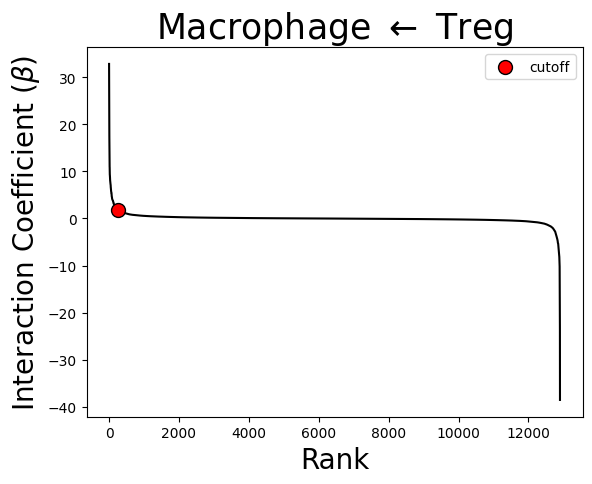

In [22]:
plt.plot(mac_treg_mean.values, color = 'black', zorder = -100)
plt.scatter(*mac_treg_top_xy, c = 'red', edgecolor = 'black', label = 'cutoff', s = 100)
plt.ylabel(r'Interaction Coefficient ($\beta$)', fontsize = 20)
plt.xlabel('Rank', fontsize = 20)
plt.title(r'Macrophage $\leftarrow$ Treg', fontsize = 25)
plt.legend()
plt.show()

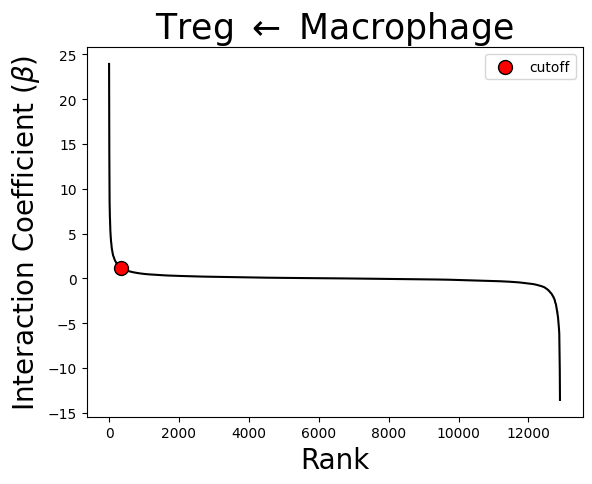

In [23]:
plt.plot(treg_mac_mean.values, color = 'black', zorder = -100)
plt.scatter(*treg_mac_top_xy, c = 'red', edgecolor = 'black', label = 'cutoff', s = 100)
plt.ylabel(r'Interaction Coefficient ($\beta$)', fontsize = 20)
plt.xlabel('Rank', fontsize = 20)
plt.title(r'Treg $\leftarrow$ Macrophage', fontsize = 25)
plt.legend()
plt.show()

### Visualize 

In [27]:
os.listdir(SC_DIR)

['P2_normal+tumor.h5ad',
 'P6_normal+tumor.h5ad',
 'P4_normal+tumor.h5ad',
 'P5_normal+tumor.h5ad',
 'P10_normal+tumor.h5ad',
 'P9_normal+tumor.h5ad']

In [28]:
ad_sc  = {x.split('_')[0]:ad.read_h5ad(osp.join(SC_DIR, x)) for x in os.listdir(SC_DIR)}
ad_sc = ad.concat(ad_sc)

In [29]:
sc.pp.normalize_total(ad_sc)
sc.pp.log1p(ad_sc)

In [30]:
sc.pp.pca(ad_sc)
sc.pp.neighbors(ad_sc)
sc.tl.umap(ad_sc)

In [68]:
sc.tl.score_genes(ad_sc, gene_list=mac_treg_top, score_name='mac_treg')

In [81]:
sc.tl.score_genes(ad_sc, gene_list=treg_mac_top, score_name='treg_mac')

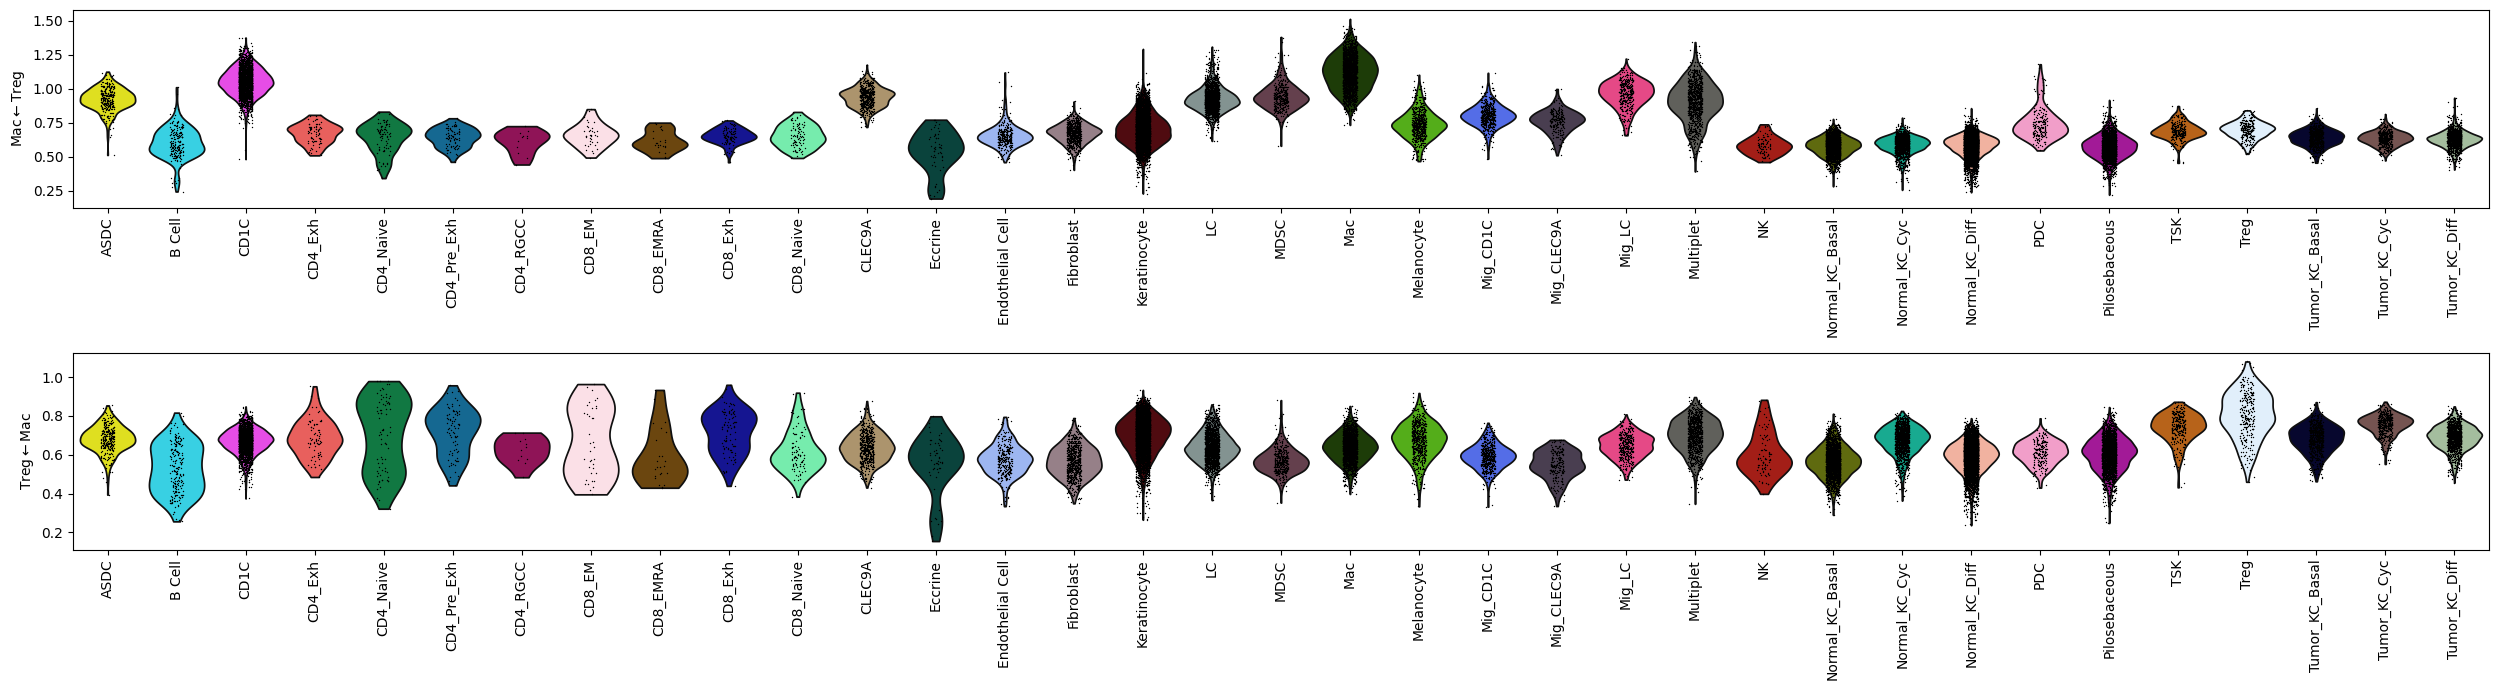

In [86]:
fig, ax = plt.subplots(2,1, figsize=(25,7))
sc.pl.violin(ad_sc, keys=['mac_treg'], groupby='level3_celltype', ax = ax[0], rotation = 90,show = False)
sc.pl.violin(ad_sc, keys=['treg_mac'], groupby='level3_celltype', ax = ax[1], rotation = 90, show = False)
ax[0].set_ylabel(r'Mac$\leftarrow$Treg',)
ax[1].set_ylabel(r'Treg$\leftarrow$Mac',)
fig.tight_layout()
plt.show()

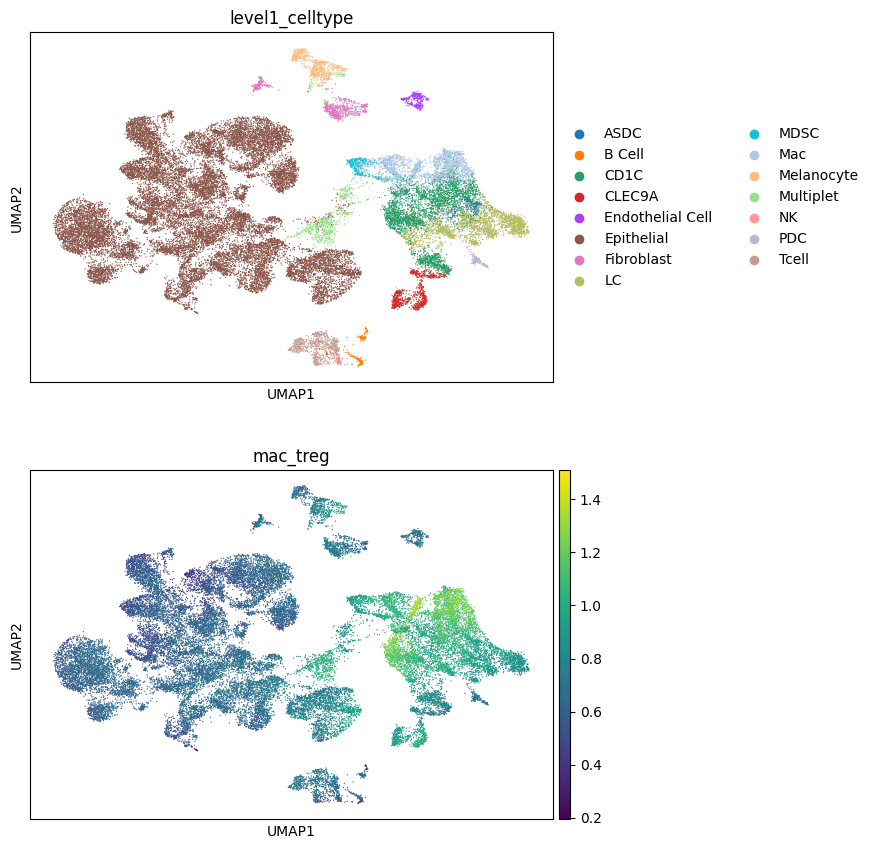

In [72]:
sc.pl.umap(ad_sc, color=['level3_celltype',], ncols = 1)

In [52]:
ad_sc.obs[label_col].value_counts()

level3_celltype
Normal_KC_Diff      6997
Keratinocyte        5252
Pilosebaceous       2721
Normal_KC_Basal     2645
CD1C                2574
Mac                 2226
LC                  2034
Normal_KC_Cyc       1466
Tumor_KC_Diff       1401
Multiplet           1005
Fibroblast           739
Tumor_KC_Basal       663
Melanocyte           638
CLEC9A               548
Mig_CD1C             535
Tumor_KC_Cyc         483
MDSC                 380
Mig_LC               368
Endothelial Cell     304
ASDC                 288
Treg                 263
TSK                  260
Mig_CLEC9A           206
PDC                  195
B Cell               195
CD8_Exh               98
CD8_Naive             89
NK                    86
CD4_Pre_Exh           83
CD4_Naive             79
CD4_Exh               75
Eccrine               53
CD8_EM                37
CD8_EMRA              24
CD4_RGCC              12
Name: count, dtype: int64